In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [ ]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf
import unicodedata

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_df = pd.read_csv("kan_sentiment_train.tsv", sep='\t')
print(len(train_df))

valid_df = pd.read_csv("kan_sentiment_dev.tsv", sep='\t')
print(len(valid_df))

test_df = pd.read_csv("kan_sentiment_test_withoutlabels.tsv", sep='\t')
len(test_df)

6212
691


768

In [ ]:
test_df

,id,text
0,Kan_1,ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇ...
1,Kan_2,Jai D Boss
2,Kan_3,Signature move
3,Kan_4,Super song bro
4,Kan_5,Wow Super agi helidira sir
...,...,...
763,Kan_764,Thu thukali trailer
764,Kan_765,Siri gannadam galge haakbitallapa Thu yaro ni...
765,Kan_766,ನಾವೇನಾದರು ಸ್ವಾಬಿಮಾನಿಯಾಗಿ ಬದುಕನ್ನು ಕಟ್ಟಿಕೊಳ್ಳಲು...
766,Kan_767,ದಿಯಾ ನೀವು ಸೋಷಿಯಲ್ ಮೀಡಿಯಾ ಅಲ್ಲಿ ಕಾಣ್ತಿಲ್ಲ.nದಯವಿ...


In [ ]:
print(test_df['text'][279])
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])

Superb video bro
sir deshadali shikshana jotege kwoshliya nu kalisabeku selp udyogada samartya barbeku nnrajakiya vektigalu adikara and hanke ase belde deshavanu munnadasabeku employment ge jobs sigo rieti nodka beku
@Kushal MR nin kano bvc jaatrr
ಹಿಂದಿ song innu yake relise agilla
I like good job
Adre niv suprb bro


In [ ]:
train_df['text'][0]

'ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನು ಅವಲಂಬಿಸುವುದಿಲ್ಲ. ಅವರು ಮಾನವೀಯತೆಯಲ್ಲಿ ಎಷ್ಟು ಸಮರ್ಥರು ಎನ್ನುವುದನ್ನು ಅವಲಂಬಿಸಿದೆ. ಭಾರತದಲ್ಲಿ ಅನಕ್ಷರತೆ ಇದೆ ಆ ಅನಕ್ಷರಸ್ಥರನ್ನು ಅವರ ಅನಕ್ಷರತೆಯೇ'

In [ ]:
train_df

,text,category
0,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,Negative
1,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Positive
2,Super sar song,not-Kannada
3,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...,Negative
4,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,Positive
...,...,...
6207,@A.R.W tumbad tanhaji andhadhun aise bahot h...,not-Kannada
6208,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്,not-Kannada
6209,Bro...nNeen este Roast madudru...China ne beku...,Negative
6210,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...,Positive


In [ ]:
valid_df

,text,category
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


In [ ]:
train_df['category'].value_counts()

Positive          2823
Negative          1188
not-Kannada        916
unknown state      711
Mixed feelings     574
Name: category, dtype: int64

In [ ]:
valid_df['category'].value_counts()

Positive          321
Negative          139
not-Kannada       110
unknown state      69
Mixed feelings     52
Name: category, dtype: int64

In [ ]:
valid_df['text']

0      Binduge saryagi ugithidira good go ahead  we a...
1                                 yen song guru ...super
2                                       my fevorat story
3                                      Super ತೋಗರಿ ತೀಪ್ಪ
4      ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...
                             ...                        
686    @Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ
687                                 Hugi guru badethawke
688                                    Trending no.1 wow
689    @Troll Stupid Fans naanu adikke kano helthirod...
690    @JustAn Opinion ninu Tika mucchu...Evattu Kann...
Name: text, Length: 691, dtype: object

In [ ]:
len(train_df)

6212

In [ ]:
for i in range(len(train_df)):
  if (train_df['category'][i] == 'Positive '):
    print(i)

In [ ]:
train_df['category'][6182]

'Positive'

In [ ]:
train_df['category'][6182] = 'Positive'
train_df['category'][6182]

'Positive'

In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


for i in range(len(train_df)):
    temp1 = deEmojify(train_df['text'][i])
    train_df['text'][i] = temp1

for j in range(len(valid_df)):
    temp2 = deEmojify(valid_df['text'][j])
    valid_df['text'][j] = temp2

for k in range(len(test_df)):
    temp3 = deEmojify(test_df['text'][k])
    test_df['text'][k]=temp3

In [ ]:
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])

sir deshadali shikshana jotege kwoshliya nu kalisabeku selp udyogada samartya barbeku nnrajakiya vektigalu adikara and hanke ase belde deshavanu munnadasabeku employment ge jobs sigo rieti nodka beku
@Kushal MR nin kano bvc jaatrr
ಹಿಂದಿ song innu yake relise agilla
I like good job
Adre niv suprb bro


In [ ]:
def preprocess_data(text):
  user_name = '@[A-Za-z0-9]+' # Pattern for matching the user names in the tweet
  has_tag = '#[A-Za-z0-9]+' # Pattern for matching the hasgtags in the tweer
  url = 'https?:\/\/[A-Za-z0-9\.\/\-]+' # Pattern for matching the URLs in the tweet
  #emoji_pattern = r'/[x{1F600}-x{1F64F}]/u'
  
  x = text.lower()  # Lower casing all the characters
  x = re.sub(user_name, '', x) # Replace the username with an empty characrer
  x = re.sub(has_tag,'',x) # Replace the hashtags with an empty characrer
  x = re.sub(url, '', x) # Replace the URLs with an empty characrer
  #x = re.sub(emoji_pattern, '', x)
  x = x.translate(str.maketrans('', '', string.punctuation)) # Replace all the characters except alphabets and digits from the tweet

  return x

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
valid_df['text'] = valid_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
test_df['text'] = test_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe

In [ ]:
print(test_df['text'][279])
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])

superb video bro
sir deshadali shikshana jotege kwoshliya nu kalisabeku selp udyogada samartya barbeku nnrajakiya vektigalu adikara and hanke ase belde deshavanu munnadasabeku employment ge jobs sigo rieti nodka beku
 mr nin kano bvc jaatrr
ಹಿಂದಿ song innu yake relise agilla
i like good job
adre niv suprb bro


In [ ]:
valid_df['text'][0]

'binduge saryagi ugithidira good go ahead  we are enjoying well'

In [ ]:
print(train_df)
print()
#print(valid_df.head())
#print()
print(valid_df)
print()
print(test_df)

                                                   text        category
0     ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...        Negative
1     ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...        Positive
2                                        super sar song     not-Kannada
3     tiktokers present situation nನೋಡುವವರು ಯಾರು ನಮ್...        Negative
4                                 super ಸಾಂಗ್ ವೆರಿ ನೈಸ್        Positive
...                                                 ...             ...
6207  rw   tumbad tanhaji andhadhun aise bahot hai p...     not-Kannada
6208                   പൊളി ഡാൻസ് രക്ഷിത് ഷെട്ടി മാസ്സ്     not-Kannada
6209  bronneen este roast madudruchina ne beku antha...        Negative
6210  ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...        Positive
6211                                         26 m views  Mixed feelings

[6212 rows x 2 columns]

                                                  text        category
0    binduge saryagi ugithidira good go

In [ ]:
train_text = train_df['text'].tolist()
valid_text = valid_df['text'].tolist()
test_text = test_df['text'].tolist()

train_label = train_df['category'].tolist()
valid_label = valid_df['category'].tolist()

In [ ]:
test_text

['ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇಷ್ಟವಾಗಿದೆ ಲೈಕ್ ಮಾಡಿಗಾಳಿ ಮಾತಿನ ಬಜಾರು ಸುದ್ದಿ ಸಾರಿದೆ',
 'jai d boss',
 'signature move',
 'super song bro',
 'wow  super agi helidira sir',
 'waiting  asn',
 'film nodidmele ee song ge addict aadavaru like maadinyalllrigu thanks for 1000 likes',
 'i like it',
 'avanige gaya vasi agbeku andreavnu krishna na bhakti madivasi madbeku eela kaliyuga nasa agbeku',
 'ಚಂದನ್ ಶೆಟ್ಟಿ ಟ್ರೊಲ್ ವಿಡಿಯೋ ನೀವು ನೋಡಿ ನೆಗಡ್ಡೆ ಇದ್ರೆ ನಾವ್ ಗ್ಯಾರಂಟಿ',
 'ಮೊದಲು ನಿನ್ನ ಗುಲಾಮು ಜಾಮ್ ಬಿದ್ದಿದ್ದ ನೋಡು',
 'sir nanu china apps na delete ಮಾಡಿದೀನಿ sir',
 'super songs super steps',
 ' kudla kannadadalli nodi kannada version views jaasti maadi',
 'supper bro chenngi ugdidira',
 'ನಾನು ಸುಮಾರು ಈ ಹಾಡನ್ನು ಹದಿನೈದು ಬಾರಿ ನೋಡಿದ್ದೇನೆ ಯಾಕೆ ಗೊತ್ತಿಲ್ಲ ಇನ್ನು ನೋಡಬೇಕು ನೋಡಬೇಕು ಅನಿಸುತ್ತದೆ ಅದೇತರ ಒಂದಕ್ಕಿಂತ ಹೆಚ್ಚು ಬಾರಿ ನೋಡುತ್ತಲೇ ಇರುವವರು ಲೈಕ್ ಮಾಡಿ',
 'nimmamman hogi alli kelsa madu gothagute',
 'idu charitrae srushtiso cinemannae',
 'yakappa yenaytu movie swalpa length jasti adre movie chennagide',
 'enn 

In [ ]:
class_names = list(set(train_label))
class_names

['Negative', 'Mixed feelings', 'unknown state', 'Positive', 'not-Kannada']

In [ ]:
len(train_label)

6212

In [ ]:
class_dist = Counter(train_label)
class_dist

Counter({'Negative': 1188,
         'Positive': 2823,
         'not-Kannada': 916,
         'Mixed feelings': 574,
         'unknown state': 711})

In [ ]:
class_dist = Counter(valid_label)
class_dist

Counter({'Mixed feelings': 52,
         'Positive': 321,
         'not-Kannada': 110,
         'Negative': 139,
         'unknown state': 69})

In [ ]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
train_label

array([1, 2, 3, ..., 1, 2, 0])

In [ ]:
valid_label = le.fit_transform(valid_label)
valid_label

array([0, 2, 3, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 1, 3, 1, 2, 2, 2, 0, 2, 2,
       1, 1, 3, 0, 1, 2, 0, 4, 2, 2, 2, 1, 3, 1, 2, 2, 1, 4, 1, 1, 2, 4,
       2, 1, 1, 2, 2, 4, 1, 2, 4, 2, 2, 2, 2, 2, 2, 3, 3, 1, 3, 2, 1, 2,
       2, 1, 0, 2, 3, 4, 2, 4, 3, 1, 2, 2, 3, 2, 3, 3, 3, 0, 2, 4, 2, 0,
       2, 3, 2, 2, 3, 2, 2, 2, 2, 0, 2, 4, 2, 3, 4, 2, 3, 1, 2, 3, 4, 1,
       2, 1, 3, 2, 1, 2, 0, 2, 2, 3, 0, 1, 2, 1, 2, 4, 2, 2, 2, 3, 2, 2,
       2, 1, 2, 4, 0, 2, 4, 4, 4, 2, 1, 2, 2, 3, 4, 1, 3, 2, 1, 2, 0, 2,
       1, 2, 1, 2, 2, 2, 2, 3, 2, 4, 2, 1, 2, 1, 2, 3, 1, 2, 2, 1, 2, 4,
       1, 0, 3, 4, 2, 1, 2, 0, 3, 2, 1, 1, 2, 2, 1, 4, 4, 4, 2, 1, 3, 2,
       2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 3, 2, 1, 4, 2, 1, 2, 0, 2,
       2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 4, 1, 2, 1,
       1, 3, 2, 1, 2, 1, 2, 2, 2, 3, 1, 2, 3, 2, 2, 2, 2, 1, 3, 3, 2, 2,
       2, 3, 2, 2, 2, 1, 2, 4, 0, 3, 4, 1, 2, 2, 1, 2, 2, 1, 3, 2, 1, 2,
       4, 2, 1, 2, 2, 3, 3, 2, 3, 3, 4, 2, 2, 4, 2,

In [ ]:
le.inverse_transform([0,1,2,3,4])

array(['Mixed feelings', 'Negative', 'Positive', 'not-Kannada',
       'unknown state'], dtype='<U14')

In [ ]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                4:sum(class_dist.values())/class_dist[le.inverse_transform([4])[0]]}

class_weight

{0: 13.288461538461538,
 1: 4.971223021582734,
 2: 2.1526479750778815,
 3: 6.281818181818182,
 4: 10.014492753623188}

In [ ]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [ ]:
words_in_train = [sent.split() for sent in train_text] # Splitting the tweet into tokens
words_in_train[0:5]

[['ಒಂದು',
  'ದೇಶದ',
  'ಮುಂದುವರಿಯುವುದು',
  'ಅದರ',
  'ಆರ್ಥಿಕ',
  'ಸ್ಥಿತಿಯನ್ನು',
  'ಅವಲಂಬಿಸುವುದಿಲ್ಲ',
  'ಅವರು',
  'ಮಾನವೀಯತೆಯಲ್ಲಿ',
  'ಎಷ್ಟು',
  'ಸಮರ್ಥರು',
  'ಎನ್ನುವುದನ್ನು',
  'ಅವಲಂಬಿಸಿದೆ',
  'ಭಾರತದಲ್ಲಿ',
  'ಅನಕ್ಷರತೆ',
  'ಇದೆ',
  'ಆ',
  'ಅನಕ್ಷರಸ್ಥರನ್ನು',
  'ಅವರ',
  'ಅನಕ್ಷರತೆಯೇ'],
 ['ಕನ್ನಡದಲ್ಲಿ',
  'ಡೈಲಿ',
  'ಟೆಕ್',
  'ಅಪ್ಡೇಟ್ಸ್',
  'ಪಡೆಯಲು',
  'ಸಬ್ಸ್ಕ್ರೈಬ್',
  'ಮಾಡಿ',
  'ನಮ್ಮ',
  'ಚನ್ನೆಲ್ಗೆ'],
 ['super', 'sar', 'song'],
 ['tiktokers',
  'present',
  'situation',
  'nನೋಡುವವರು',
  'ಯಾರು',
  'ನಮ್ಮ',
  'ವೀಡಿಯೋನೂ'],
 ['super', 'ಸಾಂಗ್', 'ವೆರಿ', 'ನೈಸ್']]

In [ ]:
words_in_valid = [sent.split() for sent in valid_text] # Splitting the tweet into tokens
words_in_valid[0:5]

[['binduge',
  'saryagi',
  'ugithidira',
  'good',
  'go',
  'ahead',
  'we',
  'are',
  'enjoying',
  'well'],
 ['yen', 'song', 'guru', 'super'],
 ['my', 'fevorat', 'story'],
 ['super', 'ತೋಗರಿ', 'ತೀಪ್ಪ'],
 ['ನಿಮ್ಮ',
  'ಮಾತುಗಳು',
  'ಅಕ್ಷರಶಃ',
  'ಸತ್ಯ',
  'ನಿಮ್ಮ',
  'ಈ',
  'ಸಾಮಾನ್ಯ',
  'ಜೀವನ',
  'ನೋಡಿ',
  'ಕುಷಿ',
  'ಆಯಿತು']]

In [ ]:
words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
words_in_test[0:5]

[['ಈ',
  'ಹಾಡನ್ನು',
  'ಹಾಡಿದ',
  'ವಿಜಯ',
  'ಪ್ರಕಾಶ',
  'voice',
  'ಯಾರಿಗೆಲ್ಲಾ',
  'ಇಷ್ಟವಾಗಿದೆ',
  'ಲೈಕ್',
  'ಮಾಡಿಗಾಳಿ',
  'ಮಾತಿನ',
  'ಬಜಾರು',
  'ಸುದ್ದಿ',
  'ಸಾರಿದೆ'],
 ['jai', 'd', 'boss'],
 ['signature', 'move'],
 ['super', 'song', 'bro'],
 ['wow', 'super', 'agi', 'helidira', 'sir']]

In [ ]:
all_words_train = list(itertools.chain(*words_in_train)) # Making a flatlist of all the words in the corpus
all_words_train[1:10]

['ದೇಶದ',
 'ಮುಂದುವರಿಯುವುದು',
 'ಅದರ',
 'ಆರ್ಥಿಕ',
 'ಸ್ಥಿತಿಯನ್ನು',
 'ಅವಲಂಬಿಸುವುದಿಲ್ಲ',
 'ಅವರು',
 'ಮಾನವೀಯತೆಯಲ್ಲಿ',
 'ಎಷ್ಟು']

In [ ]:
all_words_valid = list(itertools.chain(*words_in_valid)) # Making a flatlist of all the words in the corpus
all_words_valid[1:10]

['saryagi',
 'ugithidira',
 'good',
 'go',
 'ahead',
 'we',
 'are',
 'enjoying',
 'well']

In [ ]:
all_words_test = list(itertools.chain(*words_in_test)) # Making a flatlist of all the words in the corpus
all_words_test[1:10]

['ಹಾಡನ್ನು',
 'ಹಾಡಿದ',
 'ವಿಜಯ',
 'ಪ್ರಕಾಶ',
 'voice',
 'ಯಾರಿಗೆಲ್ಲಾ',
 'ಇಷ್ಟವಾಗಿದೆ',
 'ಲೈಕ್',
 'ಮಾಡಿಗಾಳಿ']

In [ ]:
word_counts_train = collections.Counter(all_words_train)  # Computing the number of occurrence of all the words in the corpus
word_counts_train.most_common(15)

[('super', 919),
 ('song', 474),
 ('bro', 434),
 ('sir', 415),
 ('movie', 367),
 ('guru', 332),
 ('like', 260),
 ('boss', 200),
 ('kannada', 197),
 ('i', 176),
 ('madi', 173),
 ('ge', 169),
 ('ಈ', 160),
 ('ಸೂಪರ್', 152),
 ('anna', 148)]

In [ ]:
word_counts_valid = collections.Counter(all_words_valid)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('super', 106),
 ('song', 62),
 ('sir', 50),
 ('bro', 48),
 ('movie', 39),
 ('guru', 37),
 ('like', 32),
 ('madi', 21),
 ('ಈ', 20),
 ('fans', 20),
 ('kannada', 19),
 ('nim', 19),
 ('e', 19),
 ('ge', 18),
 ('all', 15)]

In [ ]:
word_counts_valid = collections.Counter(all_words_test)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('super', 137),
 ('song', 66),
 ('sir', 57),
 ('bro', 55),
 ('movie', 46),
 ('guru', 44),
 ('ಈ', 34),
 ('like', 28),
 ('kannada', 27),
 ('madi', 25),
 ('boss', 24),
 ('ಸೂಪರ್', 24),
 ('ge', 23),
 ('film', 22),
 ('i', 22)]

In [ ]:
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

   words  count
0  super    919
1   song    474
2    bro    434
3    sir    415
4  movie    367


In [ ]:
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

   words  count
0  super    137
1   song     66
2    sir     57
3    bro     55
4  movie     46


In [ ]:
words_with_counts_test = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

   words  count
0  super    137
1   song     66
2    sir     57
3    bro     55
4  movie     46


In [ ]:
all_words = all_words_train + all_words_valid + all_words_test
corpus = train_text + valid_text + test_text
vocab_size = len(set(all_words)) # number of words to keep.
embedding_dim = 100 # Dimension of the vector representation for each word 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>"

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [ ]:
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')


test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [ ]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
print(np.shape(training_padded))
print(np.shape(valid_padded))
print(np.shape(test_padded))

(6212, 96)
(691, 96)
(768, 96)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                              embeddings_initializer='orthogonal', embeddings_regularizer='L2'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=METRICS
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           1839900   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 1,874,273
Trainable params: 1,874,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 2
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    batch_size = 256,
    callbacks=[callback],
    validation_data=(valid_padded, validation_labels),
    class_weight=class_weight
)

Epoch 1/2
25/25 [==============================] - 14s 387ms/step - loss: 8.2024 - accuracy: 0.8070 - precision: 0.6862 - recall: 0.0641 - auc: 0.6566 - val_loss: 2.4335 - val_accuracy: 0.8318 - val_precision: 0.7594 - val_recall: 0.2330 - val_auc: 0.8055
Epoch 2/2
25/25 [==============================] - 8s 320ms/step - loss: 8.1163 - accuracy: 0.8320 - precision: 0.6855 - recall: 0.2954 - auc: 0.7949 - val_loss: 3.5970 - val_accuracy: 0.8370 - val_precision: 0.7883 - val_recall: 0.2533 - val_auc: 0.8125


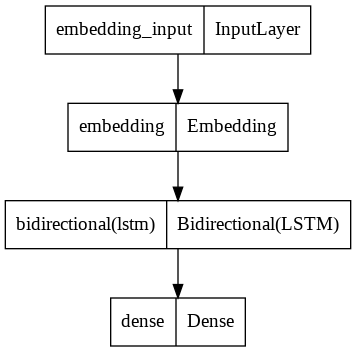

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

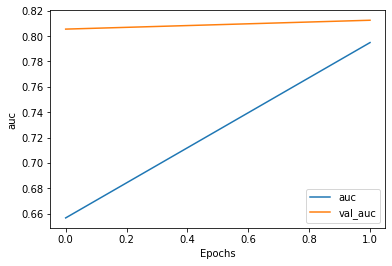

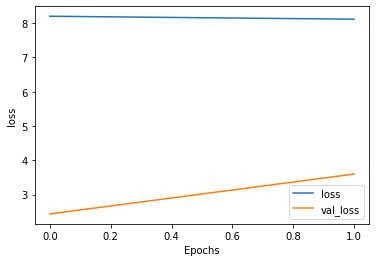

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [ ]:
score = model.evaluate(valid_padded, validation_labels)
print("Loss = {}".format(score[0]))
print("Accuracy = {0:.2f}%".format(score[1]*100))
print(score)

22/22 [==============================] - 1s 22ms/step - loss: 3.5970 - accuracy: 0.8370 - precision: 0.7883 - recall: 0.2533 - auc: 0.8125
Loss = 3.596989870071411
Accuracy = 83.70%
[3.596989870071411, 0.8370477557182312, 0.7882882952690125, 0.2532561421394348, 0.8124946355819702]


In [ ]:
y_pred = np.argmax(model.predict(valid_padded), axis=-1)
classes_y = np.argmax(y_pred,axis=-1)
accuracy = accuracy_score(valid_label, y_pred)
precision = precision_score(valid_label, y_pred, average='macro')
recall = recall_score(valid_label, y_pred, average='macro')
f1 = f1_score(valid_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

22/22 [==============================] - 1s 19ms/step
Accuracy = 53.84
Precision = 0.5143
Recall = 0.5170
F1-score = 0.4935


In [ ]:
confusion_matrix(valid_label,y_pred)

array([[ 20,   4,  16,   2,  10],
       [ 43,  70,  15,   2,   9],
       [ 54,  36, 183,  17,  31],
       [  8,   4,  21,  57,  20],
       [ 12,   1,  10,   4,  42]])

In [ ]:
print(classification_report(valid_label,y_pred))

              precision    recall  f1-score   support

           0       0.15      0.38      0.21        52
           1       0.61      0.50      0.55       139
           2       0.75      0.57      0.65       321
           3       0.70      0.52      0.59       110
           4       0.38      0.61      0.46        69

    accuracy                           0.54       691
   macro avg       0.51      0.52      0.49       691
weighted avg       0.63      0.54      0.57       691



In [ ]:
def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  class_pred = np.argmax(model.predict(reviews_padded), axis=-1)
  classes = np.argmax(class_pred,axis=-1)
  classes_prob = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(le.inverse_transform([class_pred[x]]))
    print(classes_prob[x])
    print('\n')

In [ ]:
sample_test = test_text[0:10]
sample_test

['ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇಷ್ಟವಾಗಿದೆ ಲೈಕ್ ಮಾಡಿಗಾಳಿ ಮಾತಿನ ಬಜಾರು ಸುದ್ದಿ ಸಾರಿದೆ',
 'jai d boss',
 'signature move',
 'super song bro',
 'wow  super agi helidira sir',
 'waiting  asn',
 'film nodidmele ee song ge addict aadavaru like maadinyalllrigu thanks for 1000 likes',
 'i like it',
 'avanige gaya vasi agbeku andreavnu krishna na bhakti madivasi madbeku eela kaliyuga nasa agbeku',
 'ಚಂದನ್ ಶೆಟ್ಟಿ ಟ್ರೊಲ್ ವಿಡಿಯೋ ನೀವು ನೋಡಿ ನೆಗಡ್ಡೆ ಇದ್ರೆ ನಾವ್ ಗ್ಯಾರಂಟಿ']

In [ ]:
predict_review(model, sample_test)

1/1 [==============================] - 0s 29ms/step
ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇಷ್ಟವಾಗಿದೆ ಲೈಕ್ ಮಾಡಿಗಾಳಿ ಮಾತಿನ ಬಜಾರು ಸುದ್ದಿ ಸಾರಿದೆ
['Mixed feelings']
[0.32033747 0.24360377 0.28529695 0.03015093 0.12061086]


jai d boss
['Positive']
[0.18437134 0.02836509 0.39815837 0.15804444 0.23106064]


signature move
['unknown state']
[0.1951289  0.04428166 0.06759987 0.17627148 0.51671803]


super song bro
['not-Kannada']
[0.06484117 0.00846381 0.40374374 0.42327988 0.09967148]


wow  super agi helidira sir
['Positive']
[0.12086462 0.02458482 0.5361356  0.20808911 0.11032588]


waiting  asn
['Positive']
[0.13521345 0.02071843 0.325204   0.29926825 0.2195959 ]


film nodidmele ee song ge addict aadavaru like maadinyalllrigu thanks for 1000 likes
['Positive']
[0.22739422 0.07154892 0.43834752 0.09037664 0.17233264]


i like it
['not-Kannada']
[0.11365148 0.01791974 0.08026264 0.43360543 0.35456064]


avanige gaya vasi agbeku andreavnu krishna na bhakti madivasi madbeku eela kaliyug

In [ ]:
class_pred = np.argmax(model.predict(test_padded), axis=-1)
classes = np.argmax(class_pred,axis=-1)
pred = []

for i in range(len(class_pred)):
  pred.append(le.inverse_transform([class_pred[i]])[0])

24/24 [==============================] - 1s 21ms/step


In [ ]:
pred_df = pd.DataFrame(pred, columns=['label'])
pred_df.head()

,label
0,Mixed feelings
1,Positive
2,unknown state
3,not-Kannada
4,Positive


In [ ]:
result = pd.concat([test_df, pred_df], axis=1)
result.head()

,id,text,label
0,Kan_1,ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇ...,Mixed feelings
1,Kan_2,jai d boss,Positive
2,Kan_3,signature move,unknown state
3,Kan_4,super song bro,not-Kannada
4,Kan_5,wow super agi helidira sir,Positive


In [ ]:
result.to_csv('Task Masters_kannada_task_A.tsv', sep = ',', index=False)

In [ ]:
class_pred = np.argmax(model.predict(test_padded), axis=-1)
classes = np.argmax(class_pred,axis=-1)
Valid_pred = []

for i in range(len(class_pred)):
    Valid_pred.append(le.inverse_transform([class_pred[i]])[0])

24/24 [==============================] - 0s 18ms/step


In [ ]:
class_pred.shape

(768,)

In [ ]:
Valid_pred_df = pd.DataFrame(Valid_pred, columns=['Predicted label'])
Valid_pred_df.head()

,Predicted label
0,Mixed feelings
1,Positive
2,unknown state
3,not-Kannada
4,Positive


In [ ]:
Valid_result = pd.concat([valid_df, Valid_pred_df], axis=1)
Valid_result

,text,category,Predicted label
0,binduge saryagi ugithidira good go ahead we a...,Mixed feelings,Mixed feelings
1,yen song guru super,Positive,Positive
2,my fevorat story,not-Kannada,unknown state
3,super ತೋಗರಿ ತೀಪ್ಪ,Positive,not-Kannada
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ಜೀವ...,Positive,Positive
...,...,...,...
763,NaN,NaN,Mixed feelings
764,NaN,NaN,Negative
765,NaN,NaN,Positive
766,NaN,NaN,Mixed feelings


In [ ]:
Valid_result.to_csv('Task Masters_kannada_task_A.tsv', sep = ',', index=False)

In [ ]:
valid_df

,text,category
0,binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru super,Positive
2,my fevorat story,not-Kannada
3,super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ಜೀವ...,Positive
...,...,...
686,parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,hugi guru badethawke,Negative
688,trending no1 wow,Positive
689,stupid fans naanu adikke kano helthirodu nin...,Positive


In [ ]:
d = pd.read_csv("Task Masters_kannada_task_A.tsv", sep=',')
d

,text,category,Predicted label
0,binduge saryagi ugithidira good go ahead we a...,Mixed feelings,Mixed feelings
1,yen song guru super,Positive,Positive
2,my fevorat story,not-Kannada,unknown state
3,super ತೋಗರಿ ತೀಪ್ಪ,Positive,not-Kannada
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ಜೀವ...,Positive,Positive
...,...,...,...
763,NaN,NaN,Mixed feelings
764,NaN,NaN,Negative
765,NaN,NaN,Positive
766,NaN,NaN,Mixed feelings


In [ ]:
d1 = pd.read_csv("Task Masters_kannada_task_A.tsv", sep=',')
d1

,text,category,Predicted label
0,binduge saryagi ugithidira good go ahead we a...,Mixed feelings,Mixed feelings
1,yen song guru super,Positive,Positive
2,my fevorat story,not-Kannada,unknown state
3,super ತೋಗರಿ ತೀಪ್ಪ,Positive,not-Kannada
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ಜೀವ...,Positive,Positive
...,...,...,...
763,NaN,NaN,Mixed feelings
764,NaN,NaN,Negative
765,NaN,NaN,Positive
766,NaN,NaN,Mixed feelings


In [ ]:
test_df = pd.read_csv("kan_sentiment_test_withlabels.tsv", sep='\t')

In [ ]:
test_df.head()

,id,text,category
0,Kan_1,ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇ...,Positive
1,Kan_2,Jai D Boss,unknown state
2,Kan_3,Signature move,not-Kannada
3,Kan_4,Super song bro,Positive
4,Kan_5,Wow Super agi helidira sir,Positive


In [ ]:
test_label = test_df['category'].tolist()

In [ ]:
le = LabelEncoder()

test_label = le.fit_transform(test_label)

In [ ]:
y_pred = np.argmax(model.predict(test_padded), axis=-1)
classes_y = np.argmax(y_pred,axis=-1)
accuracy = accuracy_score(test_label, y_pred)
precision = precision_score(test_label, y_pred, average='macro')
recall = recall_score(test_label, y_pred, average='macro')
f1 = f1_score(test_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

24/24 [==============================] - 0s 19ms/step
Accuracy = 51.56
Precision = 0.4797
Recall = 0.4966
F1-score = 0.4658
